<a href="https://colab.research.google.com/github/Paulooh007/Exprresso-Churn-Prediction-Challenge/blob/master/Expresso_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import warnings
warnings.simplefilter('ignore')

### Read-In Data

In [4]:
path = '/content/drive/My Drive/ExpressoChurnPredictionChallenge/'

In [5]:
train = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')

sub = pd.read_csv(path + 'sample_submission.csv')

In [6]:
train.sample(3)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
340203,1862e45a970594b991129b860305c143298cd26d,THIES,K > 24 month,9700.0,14.0,9701.0,3234.0,25.0,6995.0,14.0,127.0,4.0,NaN,NaN,NO,61,All-net 500F=2000F;5d,6.0,0
88723,92868f17b067ec37f48f50ee943d99a3f8a0c2df,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,1
303426,194a18e6279cb9c0b34ca9980b9fec80b74c9fb0,DIOURBEL,K > 24 month,900.0,3.0,900.0,300.0,5.0,2.0,56.0,NaN,NaN,NaN,NaN,NO,55,IVR Echat_Daily_50F,2.0,0


## Features Engineering and Missing values

- Simple feature interaction (addition, multiplication etc of features) using important features gotten from feature importance plot of my baseline model 
- Created more features by grouping all the numeric features by REVENUE and TENURE then performing some aggregation (mean and sum)
- Using both Label encoding and One hot encoding for REVENUE and TENURE


- Misssing values in numerical features were filled using a number that doesnt appear in the data (-999)
- Categorical features were treated as a different category ('NONE')

In [7]:
#Combining train and test to avoid repetition
test['CHURN'] = 'test'
data = pd.concat([train, test]).reset_index(drop = True)

In [8]:
mapper = { "K > 24 month": 24, 
          "I 18-21 month": 18, 
          "G 12-15 month": 12, 
          "H 15-18 month": 15, 
          "J 21-24 month": 21, 
          "F 9-12 month": 9, 
          "D 3-6 month": 3, 
          "E 6-9 month": 6   }

data['TENURE_LE'] = data['TENURE'].replace(mapper)

In [9]:
data['TENURE/REGULARITY'] = data['TENURE_LE'] / data['REGULARITY']
data['TENURE_REGULARITY'] = data['TENURE_LE'] * data['REGULARITY']
data['REVENUE-MONTANT'] = data['REVENUE'] - data['MONTANT']
data['REVENUE/MONTANT'] = data['REVENUE'] / data['MONTANT']
data['TENURE/FREQUENCE_RECH'] = data['TENURE_LE'] / data['FREQUENCE_RECH']

### Missing Values

In [10]:
cat_feat = data.select_dtypes(exclude = np.number).columns
num_feat = data.select_dtypes(exclude = object).columns

In [11]:
num_feat

Index(['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE',
       'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2',
       'REGULARITY', 'FREQ_TOP_PACK', 'TENURE_LE', 'TENURE/REGULARITY',
       'TENURE_REGULARITY', 'REVENUE-MONTANT', 'REVENUE/MONTANT',
       'TENURE/FREQUENCE_RECH'],
      dtype='object')

In [12]:
for col in num_feat:
    data[col].fillna(-999, inplace = True)   

In [13]:
for col in cat_feat:
    data[col].fillna('NONE', inplace = True)

### Groupby features

In [15]:
for col in num_feat:
    data[col + '_mean_on_reg'] = data[col].groupby(data['REGION']).transform('mean')
    data[col + '_mean_on_ten'] = data[col].groupby(data['TENURE']).transform('mean')
    
    data[col + '_sum_on_reg'] = data[col].groupby(data['REGION']).transform('sum')
    data[col + '_sum_on_ten'] = data[col].groupby(data['TENURE']).transform('sum')

In [16]:
# data.info()

In [17]:
## Label encoding and One hot encoding
data['REGION_LE'] = pd.factorize(data['REGION'])[0]

data['TOP_PACK_LE'] = pd.factorize(data['TOP_PACK'])[0]

data = pd.get_dummies(columns=['REGION', 'TENURE'], data = data)

### Feaature Selection

In [18]:
## Splitting back into train and test

train_df = data.loc[(data['CHURN'] != 'test')].reset_index(drop = True)
test_df = data.loc[(data['CHURN'] == 'test')].reset_index(drop = True)

In [19]:
train_df['CHURN'] = train_df['CHURN'].apply(int)

In [20]:
target = 'CHURN'
features = train_df.select_dtypes(include=np.number).columns.difference([target])

In [21]:
features

Index(['ARPU_SEGMENT', 'ARPU_SEGMENT_mean_on_reg', 'ARPU_SEGMENT_mean_on_ten',
       'ARPU_SEGMENT_sum_on_reg', 'ARPU_SEGMENT_sum_on_ten', 'DATA_VOLUME',
       'DATA_VOLUME_mean_on_reg', 'DATA_VOLUME_mean_on_ten',
       'DATA_VOLUME_sum_on_reg', 'DATA_VOLUME_sum_on_ten',
       ...
       'ZONE1', 'ZONE1_mean_on_reg', 'ZONE1_mean_on_ten', 'ZONE1_sum_on_reg',
       'ZONE1_sum_on_ten', 'ZONE2', 'ZONE2_mean_on_reg', 'ZONE2_mean_on_ten',
       'ZONE2_sum_on_reg', 'ZONE2_sum_on_ten'],
      dtype='object', length=120)

In [22]:
'CHURN' in features

False

# Training

In [23]:
train_df.shape
# 124 Features in total

(400000, 124)

In [24]:
seed = 2020 #Setting seed to ensure result is reproducable

In [26]:
pip install --quiet catboost

     |████████████████████████████████| 65.9MB 57kB/s 


In [31]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss



def eval_metric(y, pred):
    return log_loss(y, pred, labels=[0, 1])

k = 5
kf = StratifiedKFold(k)

params = {
    'n_estimators': 4000,
    'learning_rate': 0.01,
    'objective': 'Logloss',
    'rsm': 0.7,
    'random_seed': seed,
    'early_stopping_rounds': 300,
    'use_best_model': True
}

### Out of fold Cross validation
- Uncomment the code in the cell below to run, training takes a while

In [33]:
# loss = 0
# test_oofs = []

# for i, (tr_idx, vr_idx) in enumerate(kf.split(train_df, train_df[target])):
#   xtrain, ytrain = train_df.loc[tr_idx, features], train_df.loc[tr_idx, target]
#   xval, yval = train_df.loc[vr_idx, features], train_df.loc[vr_idx, target]

#   # training and validation
#   model = CatBoostClassifier(**params)
#   model.fit(xtrain, ytrain, eval_set=[(xval,yval)], verbose=100)
#   pred = model.predict_proba(xval)[:, -1]

#   #predicting on test set
#   predictions = model.predict_proba(test_df[features])[:, -1]
#   score = eval_metric(yval, pred)
#   #
#   loss += score/k
#   test_oofs.append(predictions)

#   print('Fold {} : {}'.format(i, score))

# print()
# print()
# print('Avg log : ', loss)

### Feature Importance Plot

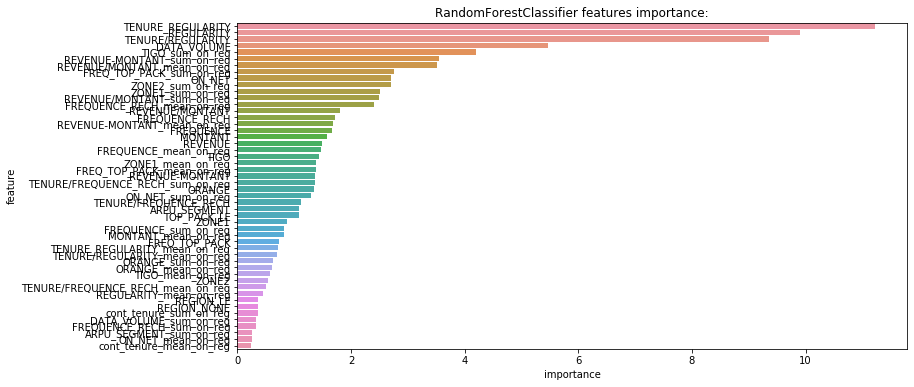

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = train_df[features].columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50))
plt.title('CatboostClassifier features importance (top 50):');

- It turned out most of the engineered really helped

# Prediction

In [ ]:
sub[target] = np.mean(test_oofs, axis=0)  #taking the mean of the out of fold predictions on the test set

In [ ]:
sub.describe()

,user_id,CHURN
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0.783745
1,5335efd940280b82143272275637d1e65d37eadb,0.661786
2,a581f4fa08677c26f83f643248c667e241043086,0.140750
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0.000880
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0.000155


# Submission

In [ ]:
sub.to_csv('submission.csv', index = False)

- My best submission on the leaderboard was a blend of two other predictions, gotten from models trainded on different sets of features with slightly different parameters but the same catboost algorithm